In [1]:
# load keys from keys/keys.json and set OPENAI_API_KEY
import json, os, pathlib
keys_path = pathlib.Path("keys/keys.json")
if keys_path.exists():
    with keys_path.open("r", encoding="utf-8") as f:
        keys = json.load(f)
    v = keys.get("OPENAI_API_KEY")
    if v:
        os.environ["OPENAI_API_KEY"] = v
print("OPENAI_API_KEY set?", bool(os.getenv("OPENAI_API_KEY")))

OPENAI_API_KEY set? True


In [4]:
# imports and config constants (refactored to per-agent modules)
import os, json, pathlib
from datetime import datetime
from typing import Dict, List
import matplotlib.pyplot as plt
from pathlib import Path
import sys

sys.path.insert(0, str(Path.cwd().parent))  # add repo root

from src.agents.common import PERSONAS, StopConfig
from src.agents.coordinator_agent import coordinator_node
from src.agents.teacher_agent import teacher_node
from src.agents.student_agent import students_node
from src.agents.critique_eval_agent import reward_node
from src.agents.stopping_agent import stopper_node

THRESHOLD = 0.7
MAX_ITERS = 5
BASE_OUT = pathlib.Path("results")
BASE_OUT.mkdir(parents=True, exist_ok=True)

In [5]:
# optional: initialize TruLens OpenAI provider to compute simple relevance
try:
    from trulens.providers.openai import OpenAI as TruOpenAI
    tru_provider = TruOpenAI(model_engine="gpt-4o-mini")
except Exception as e:
    tru_provider = None
    print("TruLens provider init failed:", e)


def trulens_relevance(question: str, explanation: str):
    """Return a simple relevance score via TruLens provider, or None if unavailable."""
    if tru_provider is None:
        return None
    try:
        res = tru_provider.relevance_with_cot_reasons(question, explanation)
        # Try to normalize to float if structure varies across versions
        if isinstance(res, dict):
            for k in ("score", "value", "score_value"):
                if k in res and res[k] is not None:
                    return float(res[k])
            return None
        # object-like
        score = getattr(res, "score", None) or getattr(res, "value", None)
        return float(score) if score is not None else None
    except Exception:
        return None

In [6]:
# build LangGraph graph for multi-agent refinement + TruLens session
from typing import Dict, List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END

class State(TypedDict, total=False):
    question: str
    topics: List[str]
    explanation: str
    student_responses: Dict[str, str]
    reward_scores: Dict[str, int]
    history: List[Dict]
    iteration: int
    threshold: float
    max_iters: int
    decision: str
    reason: str

# assemble graph with nodes imported from edu_agents.* modules
graph = StateGraph(State)

graph.add_node("coordinator", coordinator_node)

graph.add_node("teacher", teacher_node)

graph.add_node("students", students_node)

graph.add_node("reward", reward_node)

graph.add_node("stopper", stopper_node)

# edges
graph.add_edge("coordinator", "teacher")
graph.add_edge("teacher", "students")
graph.add_edge("students", "reward")
graph.add_edge("reward", "stopper")

# on CONTINUE, recompute topics first, then go to teacher
def route_from_stop(state: State) -> str:
    return "stop" if state.get("decision") == "STOP" else "continue"

graph.add_conditional_edges("stopper", route_from_stop, {"stop": END, "continue": "coordinator"})

graph.set_entry_point("coordinator")
compiled_graph = graph.compile()

# TruLens LangGraph recorder (logs interactions)
try:
    from trulens.core.database.connector.default import DefaultDBConnector
    from trulens.core.session import TruSession
    from trulens.apps.langgraph import TruGraph

    connector = DefaultDBConnector(database_url="sqlite:///edu_refine.sqlite")
    tru_session = TruSession(connector=connector)
    tru_recorder = TruGraph(compiled_graph, app_name="Educational Refinement Agent", app_version="mvp")
except Exception as e:
    tru_recorder = None
    print("TruGraph init failed:", e)

🦑 Initialized with db url sqlite:///edu_refine.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.


Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]


✅ experimental Feature.OTEL_TRACING enabled.
🔒 experimental Feature.OTEL_TRACING is enabled and cannot be changed.
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.pregel.main.Pregel'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream


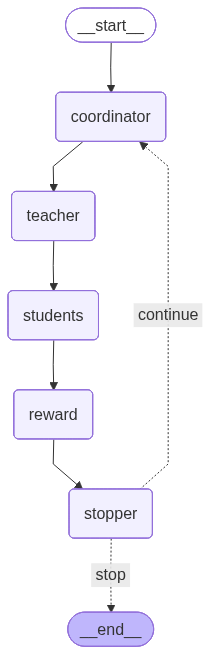

In [7]:

from IPython.display import Image

display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [8]:
# demo run on an example question using TruGraph context manager (logs to TruLens)
QUESTION = "How does gradient descent work?"
initial_state = {
    "question": QUESTION,
    "threshold": THRESHOLD,
    "max_iters": MAX_ITERS,
    "history": [],
}

# Preferred pattern: use TruGraph as a context manager to record the run
if 'tru_recorder' in globals() and tru_recorder is not None:
    with tru_recorder as recording:
        state = compiled_graph.invoke(initial_state, config={"recursion_limit": 30})
else:
    state = compiled_graph.invoke(initial_state, config={"recursion_limit": 30})

results = {
    "question": state.get("question", QUESTION),
    "topics": state.get("topics", []),
    "iterations": state.get("iteration", 0),
    "final_scores": state.get("reward_scores", {}),
    "final_explanation": state.get("explanation", ""),
    "history": state.get("history", []),
}

print("Question:", results["question"]) 
print("Topics:", ", ".join(results["topics"]))
print("Iterations:", results["iterations"]) 
print("Final scores:", results["final_scores"]) 
print("\nFinal explanation (truncated to 800 chars):\n")
print(results["final_explanation"][:800])

Question: How does gradient descent work?
Topics: high-dimensional cost function landscapes, impact of learning rate on convergence, adaptive learning rates (e.g., Adam), Stochastic Gradient Descent (SGD) mechanics, regularization techniques in gradient descent, visualization techniques for optimization, gradient descent in non-convex optimization, comparison of gradient descent variants, convergence criteria for gradient descent, trade-offs between batch size and convergence speed
Iterations: 5
Final scores: {'advanced': 3, 'struggling': 3, 'visual': 3, 'practical': 3, 'theoretical': 3}

Final explanation (truncated to 800 chars):

Gradient descent is an optimization algorithm used to minimize a cost function, often visualized as a ball rolling down a hill to find the lowest point. In high-dimensional spaces, the landscape can be complex, with many local minima. The algorithm iteratively updates parameters by moving in the direction of the negative gradient, which indicates the steepe

In [ ]:
# save outputs (final explanation + metadata) under outputs/<timestamp>
import json, pathlib
from datetime import datetime

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
out_dir = pathlib.Path("outputs")/stamp
out_dir.mkdir(parents=True, exist_ok=True)

# write final explanation
(out_dir/"final_explanation.md").write_text(results["final_explanation"], encoding="utf-8")

# write metadata json (scores, iterations, topics, history truncated summaries)
meta = {
    "question": results["question"],
    "topics": results["topics"],
    "iterations": results["iterations"],
    "final_scores": results["final_scores"],
    "history_len": len(results["history"]),
}
(out_dir/"metadata.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")

print("Saved to:", str(out_dir))

In [ ]:
# launch TruLens dashboard to view agent interactions
from trulens.dashboard import run_dashboard
run_dashboard()  # prints a local URL (e.g., http://localhost:8501); open it in your browser